In [1]:
from netCDF4 import Dataset, date2num, num2date
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

In [2]:
def getWspdAndDirs(lat, lon):
    if lat < 0:
        latUnit = 'S'
    else:
        latUnit = 'N'

    if lon < 0:
        lonUnit = 'W'
    else:
        lonUnit = 'E'

    lat = abs(lat)
    lon = abs(lon)

    myID = f'{lat:02d}{latUnit}_{lon:03d}{lonUnit}'
    larrID = f'{lat}{latUnit.lower()}{lon}{lonUnit.lower()}'

    myASfile = f'../../downloads/Buoy/extractedGZ2/WINDS/T_{myID}_matchupNearestFour_2007.nc'
    larryASfile = f'../../downloads/larryNielData/larry2020/EXP9/fromLarry_{larrID}_data.nc'

    mDS = Dataset(myASfile)
    lDS = Dataset(larryASfile)

    cdfTime = mDS.variables['time']
    timeUnit = cdfTime.units
    timeArr = np.array(cdfTime)
    cftimes=num2date(timeArr, timeUnit)
    myTime = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    mWspd = np.array(mDS.variables['U10N_AS'][0])
    mWdir = (-np.array(mDS.variables['U10N_dir_AS'][0])+450)%360


    ####

    print(np.nanmax(mWdir), np.nanmax(mWdir))
    mask = np.logical_or(abs(mWspd) > 1000,abs(mWdir) == 0)
    mWspd[mask] = float('nan')
    mWdir[mask] = float('nan')

    mWspd_TAO = np.array(mDS.variables['U10N_TAO'])
    mWdir_TAO = (-np.array(mDS.variables['U10N_dir_TAO'])+450)%360

    mWspd_TAO[abs(mWspd_TAO) > 1000] = float('nan')
    mWdir_TAO[abs(mWspd_TAO) > 1000] = float('nan')



    cdfTime = lDS.variables['time']
    timeUnit = 'days since 0001-01-01 00:00:0.0'
    timeArr = np.array(cdfTime)
    cftimes=num2date(timeArr, timeUnit, has_year_zero=True)
    larryTime = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) - timedelta(365) for dtm in cftimes])

    lWspd = np.array(lDS.variables['sat_wspd10n'])
    u = np.array(lDS.variables['sat_u10n'])
    v = np.array(lDS.variables['sat_v10n'])
    lWdir = np.rad2deg(np.arctan2(v,u))%360

    lWspd_TAO = np.array(lDS.variables['buoy_wspd10n'])
    u = np.array(lDS.variables['buoy_u10n'])
    v = np.array(lDS.variables['buoy_v10n'])

    lWdir_TAO = np.rad2deg(np.arctan2(v,u))%360


    return myTime, mWspd, mWdir, mWspd_TAO, mWdir_TAO, larryTime, lWspd, lWdir, lWspd_TAO, lWdir_TAO


def compareData(myTime, mWspd, mWdir, mWspd_TAO, mWdir_TAO, larryTime, lWspd, lWdir, lWspd_TAO, lWdir_TAO):

    selMyTime = []
    myWspd = []
    myWdir = []
    myWspd_TAO = []
    myWdir_TAO = []

    selLarryTime = []  
    larryWspd = []
    larryWdir = []
    larryWspd_TAO = []
    larryWdir_TAO = []


    for myTimeIndx in range(len(myTime)):
        curTime = myTime[myTimeIndx]
        timeDiff = curTime - larryTime
        timeDiffInSecs = np.zeros(len(timeDiff), dtype=float)
        for i in range(len(timeDiff)):
            timeDiffInSecs[i] = timeDiff[i].days * 24*3600 + timeDiff[i].seconds
        mask = abs(timeDiffInSecs) < 60*8
        if sum(mask)>0:
            
            larryTimeIndx = np.argmin(abs(timeDiffInSecs))

            selLarryTime.append(larryTime[larryTimeIndx])
            larryWspd.append(lWspd[larryTimeIndx])
            larryWdir.append(lWdir[larryTimeIndx])
            larryWspd_TAO.append(lWspd_TAO[larryTimeIndx])
            larryWdir_TAO.append(lWdir_TAO[larryTimeIndx])
                
            selMyTime.append(myTime[myTimeIndx])
            myWspd.append(mWspd[myTimeIndx])
            myWdir.append(mWdir[myTimeIndx])
            myWspd_TAO.append(mWspd_TAO[myTimeIndx])
            myWdir_TAO.append(mWdir_TAO[myTimeIndx])

    timeCompare = np.array([selMyTime, selLarryTime])

    wspdCompare = np.array([myWspd, larryWspd])
    wspd_TAOCompare = np.array([myWspd_TAO, larryWspd_TAO])

    wdirCompare = np.array([myWdir, larryWdir])
    wdir_TAOCompare = np.array([myWdir_TAO, larryWdir_TAO])

    return timeCompare, wspdCompare, wspd_TAOCompare, wdirCompare, wdir_TAOCompare




In [3]:
lat= -8 
lon= -125
myTime, mWspd, mWdir, mWspd_TAO, mWdir_TAO, larryTime, lWspd, lWdir, lWspd_TAO, lWdir_TAO = getWspdAndDirs(lat, lon)

timeCompare, wspdCompare, wspd_TAOCompare, wdirCompare, wdir_TAOCompare = compareData(myTime, mWspd, mWdir, mWspd_TAO, mWdir_TAO, larryTime, lWspd, lWdir, lWspd_TAO, lWdir_TAO)

245.5 245.5


Text(0.1, 0.9, 'corr = 0.12')

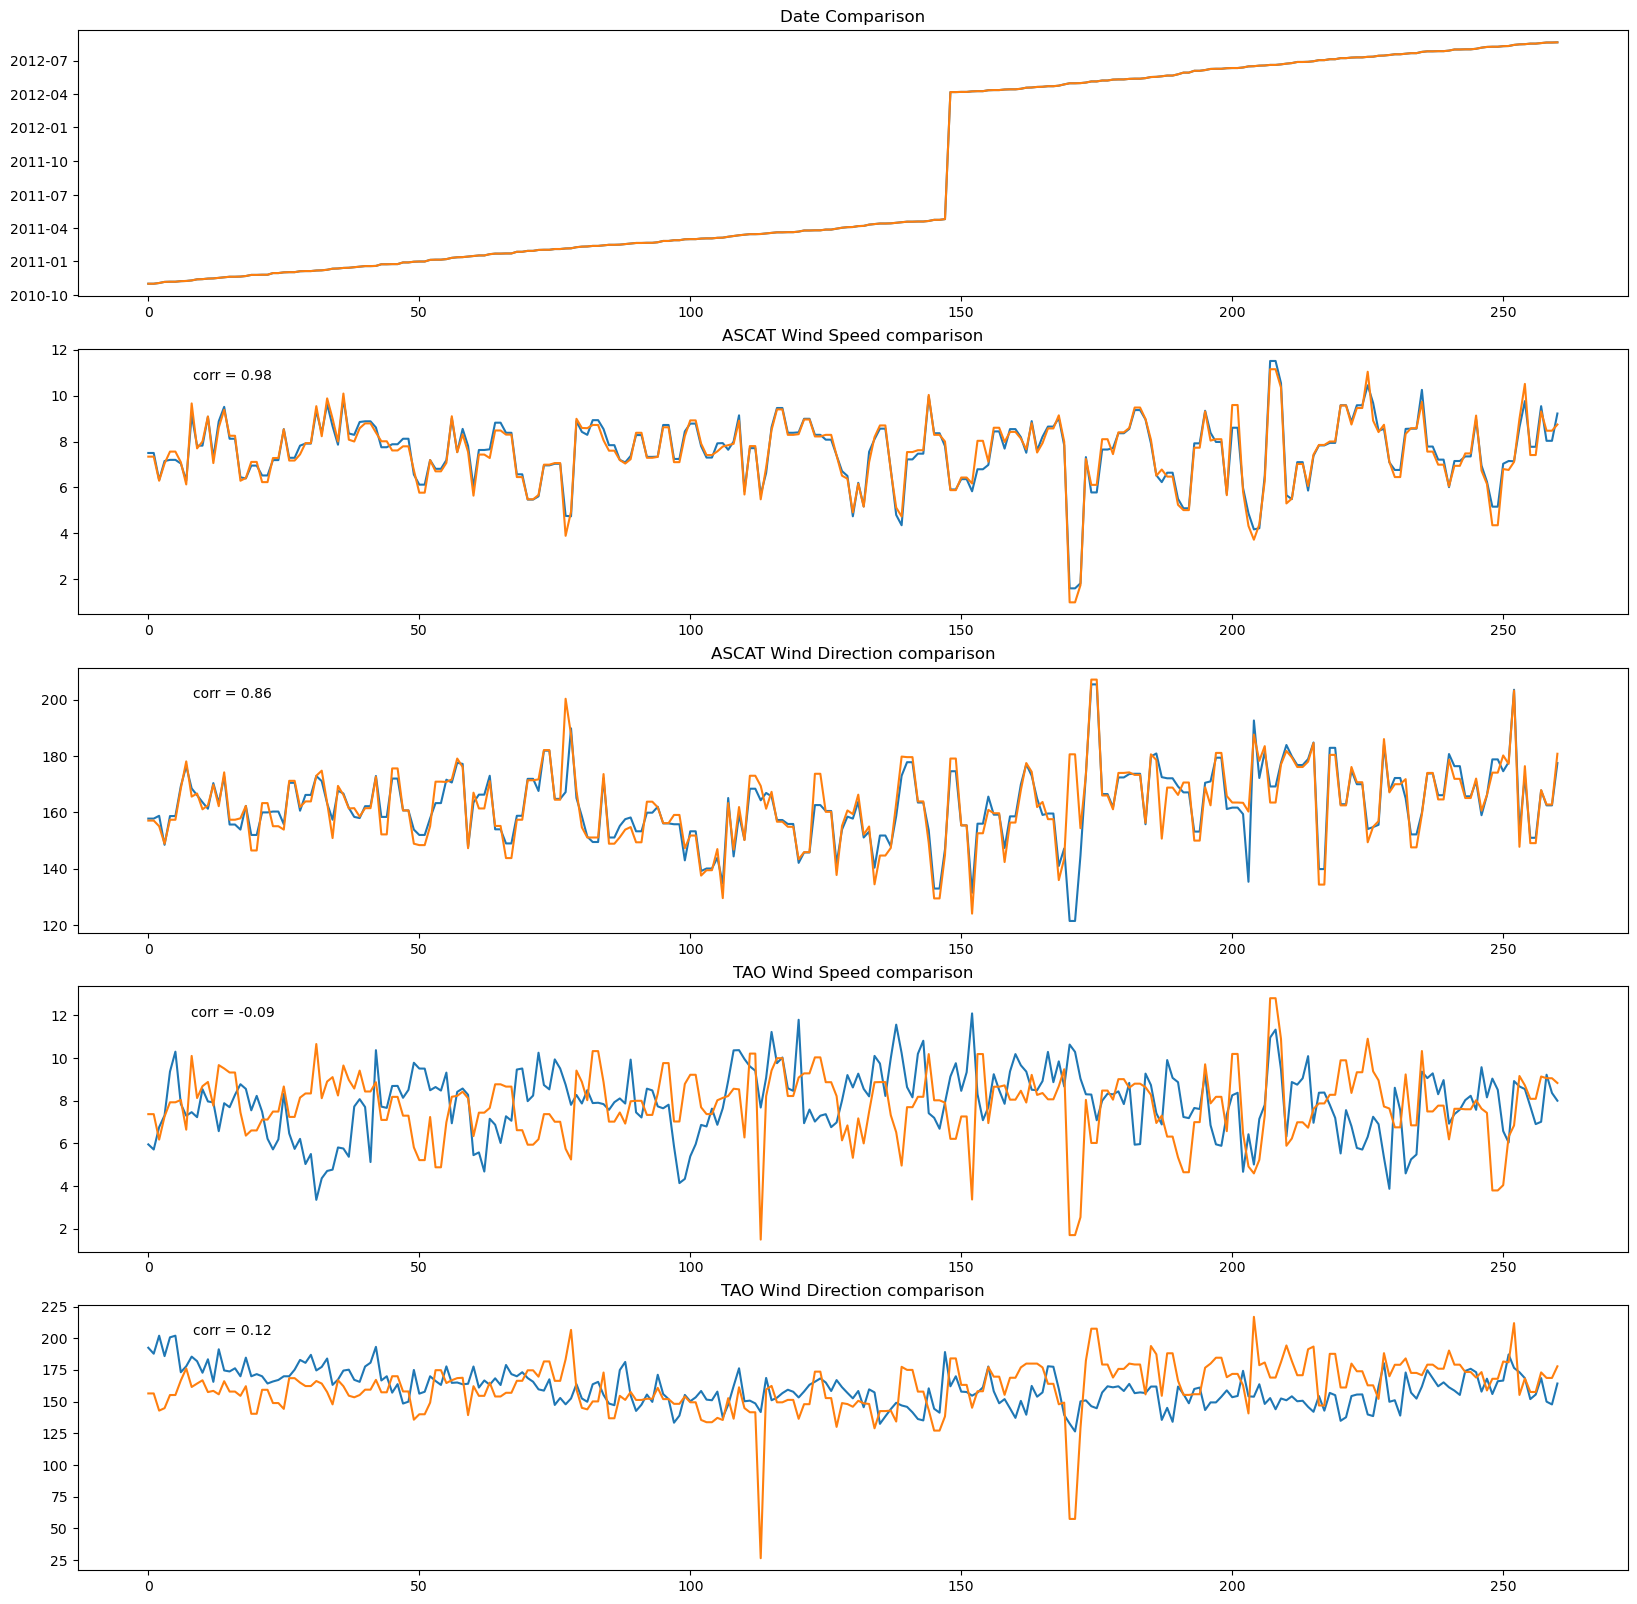

In [4]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (20,20))
ax = axes[0]
ax.plot(timeCompare.T)
ax.set_title('Date Comparison')

ax = axes[1]
ax.plot(wspdCompare.T)
ax.set_title('ASCAT Wind Speed comparison')
r = np.corrcoef(wspdCompare[0,:], wspdCompare[1,:])[0,1]
text = f'corr = {r:4.2f}'
ax.text(0.1, 0.9, text,horizontalalignment='center',
       verticalalignment='center', transform=ax.transAxes)

ax = axes[2]
ax.plot(wdirCompare.T)
ax.set_title('ASCAT Wind Direction comparison')
r = np.corrcoef(wdirCompare[0,:], wdirCompare[1,:])[0,1]
text = f'corr = {r:4.2f}'
ax.text(0.1, 0.9, text,horizontalalignment='center',
       verticalalignment='center', transform=ax.transAxes)

ax = axes[3]
ax.plot(wspd_TAOCompare.T)
ax.set_title('TAO Wind Speed comparison')
r = np.corrcoef(wspd_TAOCompare[0,:], wspd_TAOCompare[1,:])[0,1]
text = f'corr = {r:4.2f}'
ax.text(0.1, 0.9, text,horizontalalignment='center',
       verticalalignment='center', transform=ax.transAxes)

ax = axes[4]
ax.plot(wdir_TAOCompare.T)
r = np.corrcoef(wdir_TAOCompare[0,:], wdir_TAOCompare[1,:])[0,1]
text = f'corr = {r:4.2f}'
ax.set_title('TAO Wind Direction comparison')
ax.text(0.1, 0.9, text,horizontalalignment='center',
       verticalalignment='center', transform=ax.transAxes)